In [50]:
# Import module
from data import YahooFinanceApi, create_connection
from data import SQLRepository

# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Read in data

In [2]:
# Fetch data through customised class
ticker = "BTC-USD"
df = YahooFinanceApi(ticker).fetch_data()
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,42265.187500,16397498810
2024-01-01,42280.234375,44175.437500,42214.976562,44167.332031,44167.332031,18426978443
2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750,44957.968750,39335274536


In [3]:
# Create connection using a customised method
my_con = create_connection("test_run")

In [4]:
# Instatiate repository
repo = SQLRepository(my_con)

In [5]:
# Insert data gotten through API to SQL database
repo.insert_table(ticker, df, if_exists= "replace")

{'transaction_successful': True, 'records_inserted': 3397}

In [7]:
# Fetch data from SQL database
df = repo.read_table(ticker, limit = 2500)

### Perform EDA on data

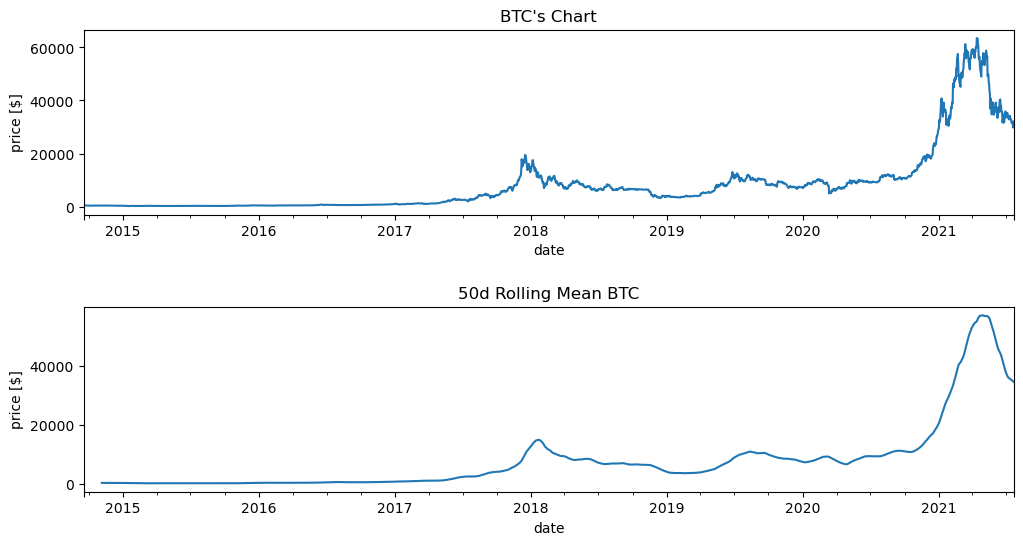

In [21]:
fig, axs = plt.subplots(2,1, figsize = (12,6))

df["close"].plot(ax = axs[0], title = "BTC's Chart", ylabel = "price [$]")

df["close"].rolling(50).mean().plot(ax = axs[1], title = "50d Rolling Mean BTC", ylabel = "price [$]")

plt.subplots_adjust(hspace= 0.5)

In [29]:
returns = df["close"].pct_change()* 100

<Axes: xlabel='date'>

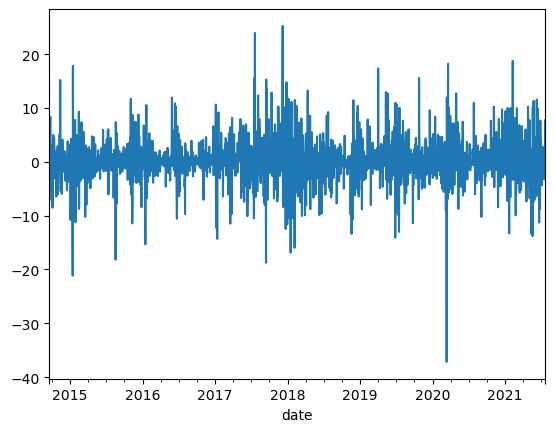

In [30]:
returns.fillna(0).plot()

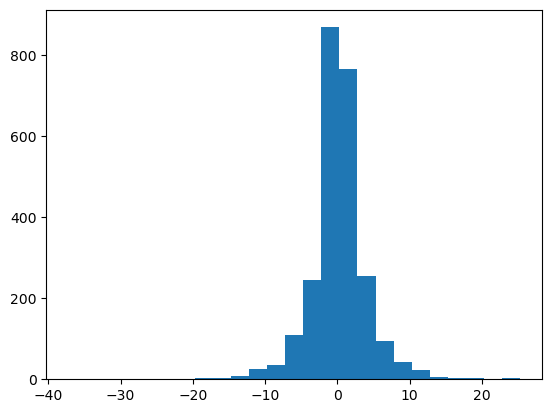

In [31]:
plt.hist(returns, bins = 25);

### Calculate daily and annual volatility

In [34]:
daily_volatility = returns.std()

print(f"{ticker}'s daily volatility is {daily_volatility}")

BTC-USD's daily volatility is 3.923336164085567


In [35]:
annual_volatility = returns.std() * np.sqrt(356)
print(f"{ticker}'s annual volatility is {annual_volatility}")

BTC-USD's annual volatility is 74.02535869339714


Calculate rolling volatility of the asset

In [36]:
rolling_50d_volatility = returns.rolling(50).std().dropna()
rolling_50d_volatility.head()

date
2014-11-06    3.465326
2014-11-07    3.335054
2014-11-08    3.199743
2014-11-09    3.245128
2014-11-10    3.232449
Name: close, dtype: float64

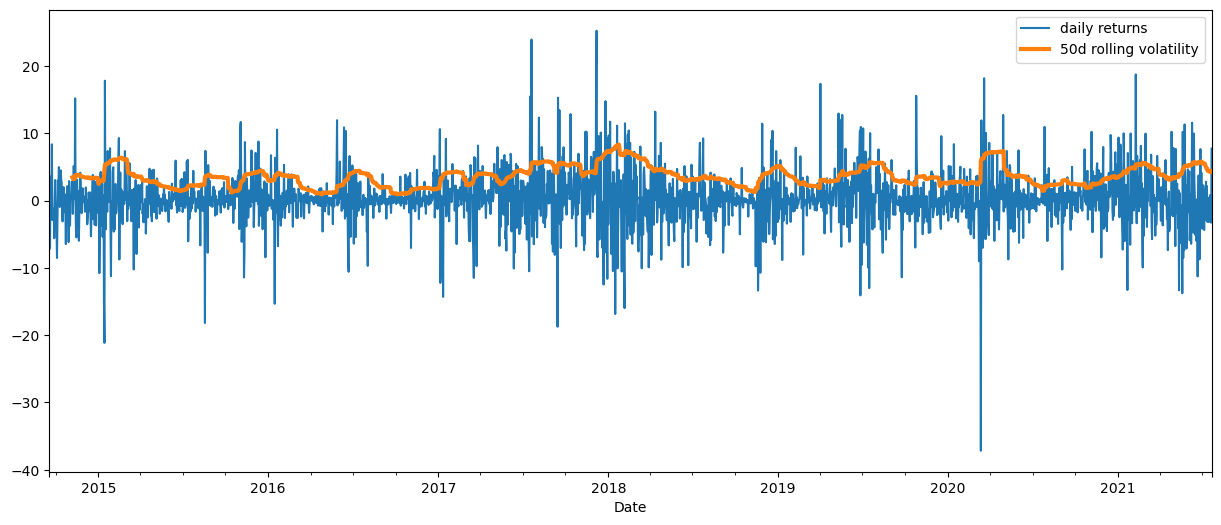

In [46]:
fig, ax = plt.subplots(figsize = (15,6))

returns.plot(ax =ax, label = "daily returns")
rolling_50d_volatility.plot(ax = ax, linewidth = 3, label = "50d rolling volatility")

plt.xlabel("Date")

plt.legend();

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. We can also see volatility go down in August 2022, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.

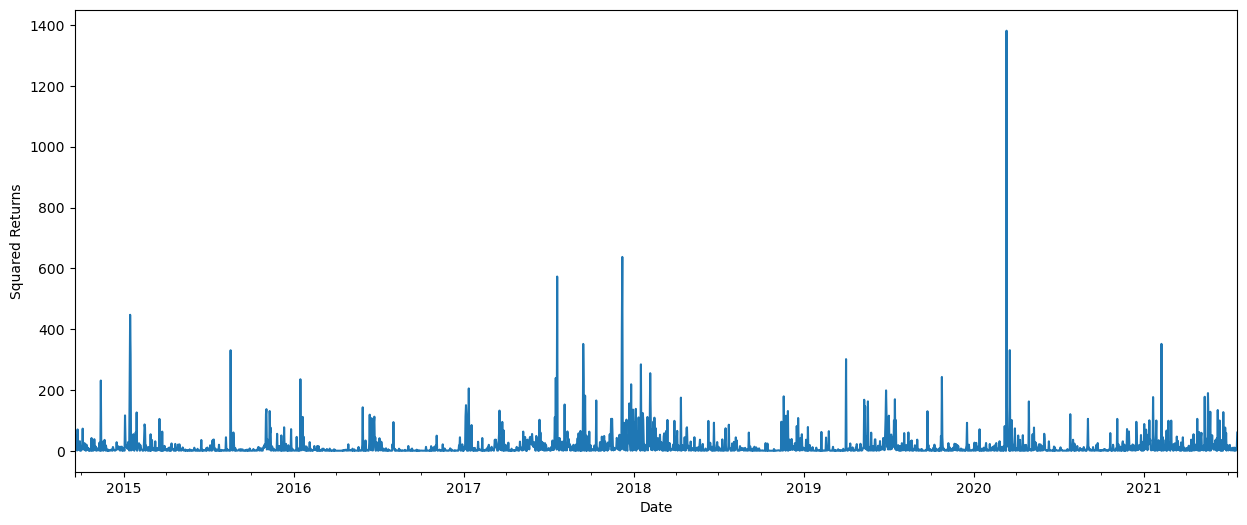

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(returns ** 2).plot()

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

Now it's much easier to see that:

1. we have periods of high and low volatility, and 
2. high volatility days tend to cluster together. 

